<a href="https://colab.research.google.com/github/srijabotlaguduru/WhatsappChatAnalyzer/blob/main/WhatsappChatAnalyzer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
import os
import re
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import string

In [27]:
# ---------- Parse the Chat ----------
def parse_chat(file_path):
    with open(file_path, encoding='utf-8') as f:
        lines = f.readlines()

    # Handles format: [18/05/23, 3:53:03 PM] Name: message
    pattern = r'^\[?(\d{1,2}/\d{1,2}/\d{2,4}), (\d{1,2}:\d{2}:\d{2})\u202f?(AM|PM)\] (.*?): (.*)'
    messages = []

    for line in lines:
        match = re.match(pattern, line)
        if match:
            date, time, am_pm, sender, message = match.groups()
            time = f"{time} {am_pm}"
            messages.append((date, time, sender, message))

    df = pd.DataFrame(messages, columns=["Date", "Time", "Sender", "Message"])

    if df.empty:
        print("⚠️ No messages parsed! Sample line:\n", repr(lines[0]))
    else:
        df["Datetime"] = pd.to_datetime(df["Date"] + " " + df["Time"], format='%d/%m/%y %I:%M:%S %p', errors='coerce')

    return df

In [6]:
# ---------- Parse All Chats in Folder ----------
def parse_all_chats(folder_path):
    all_messages = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"):
            full_path = os.path.join(folder_path, filename)
            all_messages.extend(parse_chat(full_path))

    df = pd.DataFrame(all_messages, columns=["Date", "Time", "Sender", "Message", "ChatFile"])
    df["Date"] = pd.to_datetime(df["Date"], dayfirst=True)
    return df

In [10]:
# ---------- Count Messages ----------
def count_messages(df):
    counts = df["Sender"].value_counts().reset_index()
    counts.columns = ["Sender", "Message Count"]
    return counts

In [52]:
# ---------- Activity Trend ----------
def plot_activity_trend(df, start_date, end_date, frequency='M'):
  """
  Plots message trends based on a given time range (start_date to end_date).
  Frequency can be 'Y' (year), 'M' (month), 'W' (week).
  """
  # Ensure the 'Datetime' column is in datetime format (if not already)
  df['Datetime'] = pd.to_datetime(df['Datetime'], format='%d/%m/%Y', errors='coerce')

  # Filter the data based on the start and end dates
  mask = (df['Datetime'] >= start_date) & (df['Datetime'] <= end_date)
  df_filtered = df[mask]

  if df_filtered.empty:
    print("No data available for the selected date range.")
    return

  # Set 'Datetime' as the index for resampling
  df_filtered.set_index('Datetime', inplace=True)

  # Resample based on the frequency provided ('Y' for years, 'M' for months, 'W' for weeks)
  if frequency.upper() == 'Y':
    trend = df_filtered.resample('Y').size()  # Number of messages per year
  elif frequency.upper() == 'M':
    trend = df_filtered.resample('ME').size()  # Number of messages per month
  elif frequency.upper() == 'W':
    trend = df_filtered.resample('W-SUN').size()  # Number of messages per week
  else:
    print("Invalid frequency. Use 'Y', 'M', or 'W'.")
    return

  # Plot the trend
  plt.figure(figsize=(10, 6))
  trend.plot(kind='line', marker='o', linestyle='-', color='b')
  plt.title(f'Message Trend ({frequency})', fontsize=14)
  plt.xlabel(f'{frequency.capitalize()}s', fontsize=12)
  plt.ylabel('Number of Messages', fontsize=12)
  plt.grid(True)
  plt.xticks(rotation=45)
  plt.show()


In [72]:
# ---------- Most Used Words per User ----------
def most_used_words(df, top_n=10):
  user_words = {}

  stopwords = set([
  "the", "to", "and", "i", "you", "a", "in", "is", "it", "of", "for", "on", "me", "this",
  "that", "my", "with", "was", "but", "are", "have", "not", "at", "be", "so", "we", "just", "aa", "ga", "ani", "em", "will", "what", "so", "yes", "no", "ra", "ha", "haa", "le", "lee", "lo", "ala", "ki", "ok", "okay"
  ])

  for sender in df['Sender'].unique():
    messages = df[df['Sender'] == sender]['Message']

    # Clean and join all messages into one text blob
    full_text = ' '.join(messages)

    # Remove invisible characters like \u200e and any non-word characters
    clean_text = re.sub(r'[\u200e]', '', full_text)  # remove left-to-right mark
    clean_text = re.sub(r'[^a-zA-Z0-9\s]', '', clean_text)  # remove special characters
    clean_text = clean_text.lower()  # lowercase for uniformity

    # Tokenize
    words = clean_text.split()

    # Filter out stopwords and short words
    filtered_words = [word for word in words if word not in stopwords and len(word) > 1]

    # Count and get most common
    common_words = Counter(filtered_words).most_common(top_n)
    user_words[sender] = common_words

  return user_words

In [47]:
def chats():
  ans = input("Do you want to parse all chats in a folder? (y/n) ")

  if ans.lower() == 'y':
    folder = input("Enter folder name\n")
    chat_df = parse_all_chats(folder)
  else:
    chat_name = input("Enter relative chat path i.e. (name.txt) \n")
    chat_df = parse_chat(chat_name)

  return chat_df

In [38]:
def plot_graph():
  graph_time = input("Do you want yearly(Y) or monthly(M) or weekly(W) basis?\n")
  if graph_time.lower() != 'y' and graph_time.lower() != 'm' and graph_time.lower() != 'w':
    print("Invalid input")
    return False

  start_date = input("Enter start date (DD-MM-YYYY): ")
  end_date = input("Enter end date (DD-MM-YYYY): ")
  print("Generating Activity Trend...\n")
  plot_activity_trend(chat_df, start_date, end_date,)

  return True

In [68]:
def most_words_call(df):
  print("\n\nMost Used Words by Each User:\n")
  word_stats = most_used_words(df)

  for user, words in word_stats.items():
    print(f"\n{user}\n")
    for word, count in words:
      print(f"{word}: {count}")

Do you want to parse all chats in a folder? (y/n) n
Enter relative chat path i.e. (name.txt) 
nayan_shakthi.txt
Top Message Senders:

                                           Sender  Message Count
0                               Srija Botlaguduru           3126
1                                           Fetus           1081
2                                  Pentala Raja 👑            932
3                                         Meta AI             29
4  Two waste people and Srija the Sweet Person 🥹🫶             13 

Do you want graph? (y/n) y
Do you want yearly(Y) or monthly(M) or weekly(W) basis?
m
Enter start date (DD-MM-YYYY): 01-12-2024
Enter end date (DD-MM-YYYY): 16-04-2025
Generating Activity Trend...



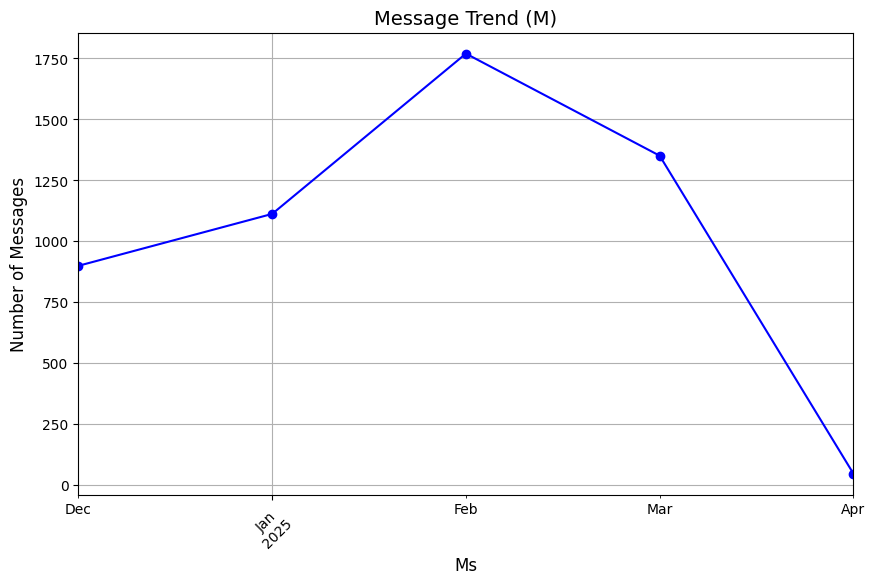



Most Used Words by Each User:


Two waste people and Srija the Sweet Person 🥹🫶

group: 10
changed: 10
description: 6
messages: 4
people: 3
read: 3
meta: 3
name: 3
srija: 3
endtoend: 2

Srija Botlaguduru

bro: 114
im: 66
dont: 64
like: 60
mowa: 57
nen: 45
918688435906: 42
message: 39
mean: 35
can: 35

Fetus

mowa: 42
only: 14
or: 14
nenu: 13
if: 12
dont: 12
nuvvu: 11
917337544093: 11
do: 11
how: 11

Pentala Raja 👑

nenu: 38
ante: 29
only: 25
naku: 23
mowa: 20
neku: 19
13135550002: 18
am: 17
enduku: 17
ne: 16

Meta AI

message: 23
edited: 23
or: 22
im: 19
can: 19
your: 16
help: 13
whatsapp: 10
something: 9
if: 9


In [78]:
# ---------- Example Usage ----------
if __name__ == "__main__":

# --------- To check if we have to parse more than one chat or just one chat --------------------
  chat_df = chats()

# ---------- Number of messages in descending order -----------------------------------------
  print("Top Message Senders:\n")
  print(count_messages(chat_df), "\n")

# ------------------ Calling for a graph ---------------------
  want_graph = input("Do you want graph? (y/n) ")

  if want_graph.lower() == "y":
    while not plot_graph():
      plot_graph()

# --------------- Most used words ------------------------------
  most_words_call(chat_df)
